### Catboost3
* added feature engineering
* added year, removed temp
* extended with prevision on entire train set to compare

In [1]:
import pandas as pd
import numpy as np
import catboost as cat

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
print(cat.__version__)

1.0.3


In [3]:
# globals
FIGSIZE = (9, 6)

SEED = 42

FILE_TRAIN = "train.csv"

In [4]:
#
# my split in train, test set
#
def my_train_test_split(df, frac):
    # frac: the fraction used for train
    # df: the dataframe

    # shuffle before split
    df = df.sample(frac=1.0, random_state=SEED)

    # FRAC = 0.90
    tot_rec = df.shape[0]
    NUM_TRAIN = int(frac * tot_rec)
    NUM_TEST = tot_rec - NUM_TRAIN

    data_train = df[:NUM_TRAIN]
    data_test = df[NUM_TRAIN:]

    print()
    print("Numero totale di campioni:", tot_rec)
    print("Numero di campioni nel TRAIN SET:", data_train.shape[0])
    print("Numero di campioni nel TEST SET:", data_test.shape[0])

    return data_train, data_test

In [5]:
data_orig = pd.read_csv(FILE_TRAIN)

# feature engineering
data_orig["datetime"] = pd.to_datetime(data_orig["datetime"])

# this way I add 3 engineered features
data_orig["hour"] = data_orig["datetime"].dt.hour

# mese di fatto è duplicato di season. rimuovo
# data_orig['month'] = data_orig['datetime'].dt.month
data_orig["day"] = data_orig["datetime"].dt.day
data_orig["year"] = data_orig["datetime"].dt.year

In [6]:
data_orig.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day,year
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,19,19,2012
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,20,19,2012
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,21,19,2012
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,22,19,2012
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88,23,19,2012


In [7]:
all_columns = data_orig.columns

# colonne da ignorare
# atemp and temp are strongly correlated (0.98) taking only one
del_columns = ["datetime", "casual", "registered", "temp"]

TARGET = "count"

cat_cols = ["season", "holiday", "workingday", "weather", "hour", "day", "year"]

num_cols = list(set(all_columns) - set([TARGET]) - set(del_columns) - set(cat_cols))

features = sorted(cat_cols + num_cols)

print("Tutte le colonne:", len(all_columns))
print("Colonne ignorate:", len(del_columns))
print("target:", len([TARGET]))
print("Colonne cat:", len(cat_cols))
print("Colonne num:", len(num_cols))
print("Num. features", len(features))

Tutte le colonne: 15
Colonne ignorate: 4
target: 1
Colonne cat: 7
Colonne num: 3
Num. features 10


In [8]:
data_used = data_orig.drop(del_columns, axis=1)

In [9]:
FRAC = 0.90

data_train, data_test = my_train_test_split(data_used, frac=FRAC)


Numero totale di campioni: 10886
Numero di campioni nel TRAIN SET: 9797
Numero di campioni nel TEST SET: 1089


In [10]:
# separo X ed y
x_train = data_train[features]
y_train = data_train[TARGET]

x_test = data_test[features]
y_test = data_test[TARGET]

# cat boost want indexes
cat_columns_idxs = [i for i, col in enumerate(x_train.columns) if col in cat_cols]

In [11]:
%%time

params = {"iterations": 6000, "learning_rate": 0.005, "depth": 10, "task_type": "GPU"}

model = cat.CatBoostRegressor(**params)

model.fit(
    x_train,
    y_train,
    cat_columns_idxs,
    verbose=500,
    early_stopping_rounds=50,
    eval_set=(x_test, y_test),
)

0:	learn: 180.9128001	test: 176.8483187	best: 176.8483187 (0)	total: 95.6ms	remaining: 9m 33s
500:	learn: 64.7608614	test: 61.4559015	best: 61.4559015 (500)	total: 39.2s	remaining: 7m 10s
1000:	learn: 52.0188622	test: 50.2419422	best: 50.2419422 (1000)	total: 1m 19s	remaining: 6m 35s
1500:	learn: 48.2550935	test: 47.3356880	best: 47.3356880 (1500)	total: 1m 57s	remaining: 5m 53s
2000:	learn: 46.0635027	test: 45.8282316	best: 45.8282316 (2000)	total: 2m 35s	remaining: 5m 10s
2500:	learn: 44.7341437	test: 45.0739648	best: 45.0739648 (2500)	total: 3m 12s	remaining: 4m 29s
3000:	learn: 43.8088842	test: 44.5931383	best: 44.5931383 (3000)	total: 3m 50s	remaining: 3m 50s
3500:	learn: 43.1813143	test: 44.3333437	best: 44.3333437 (3500)	total: 4m 24s	remaining: 3m 9s
4000:	learn: 42.6592998	test: 44.0948608	best: 44.0948608 (4000)	total: 4m 57s	remaining: 2m 28s
4500:	learn: 42.0757542	test: 43.8195492	best: 43.8195492 (4500)	total: 5m 32s	remaining: 1m 50s
5000:	learn: 41.5581855	test: 43.6084

In [12]:
history = model.evals_result_

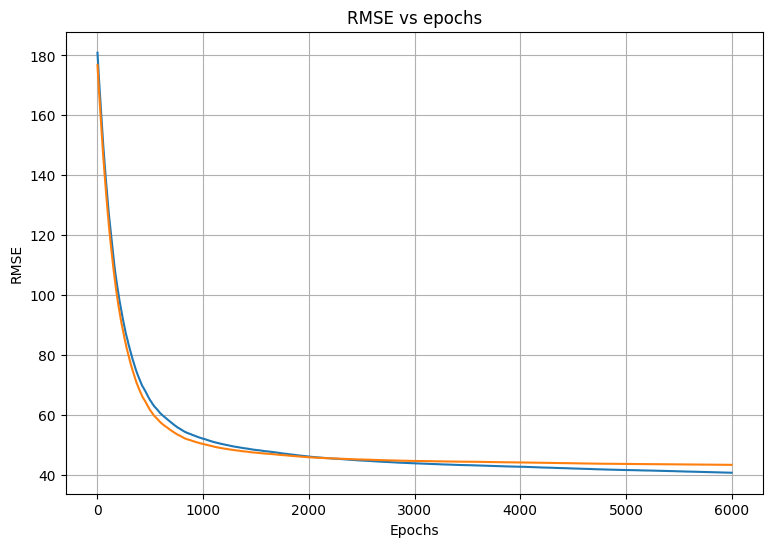

In [13]:
plt.figure(figsize=FIGSIZE)
plt.title("RMSE vs epochs")
plt.plot(history["learn"]["RMSE"])
plt.plot(history["validation"]["RMSE"])
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.grid(True)
plt.show();

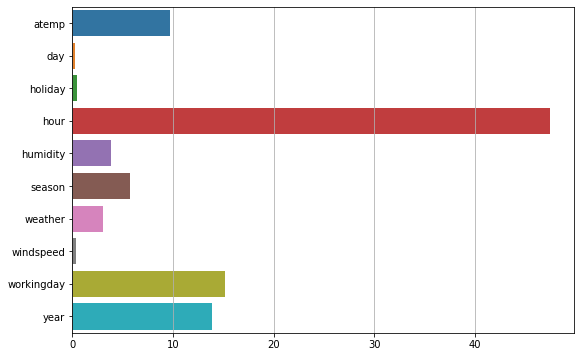

In [14]:
%matplotlib inline

# eXplainability: Feature importance


plt.figure(figsize=FIGSIZE)
plt.grid(True)
sns.barplot(x=model.get_feature_importance(), y=features);

### Test on training set

In [15]:
y_pred = model.predict(x_train)

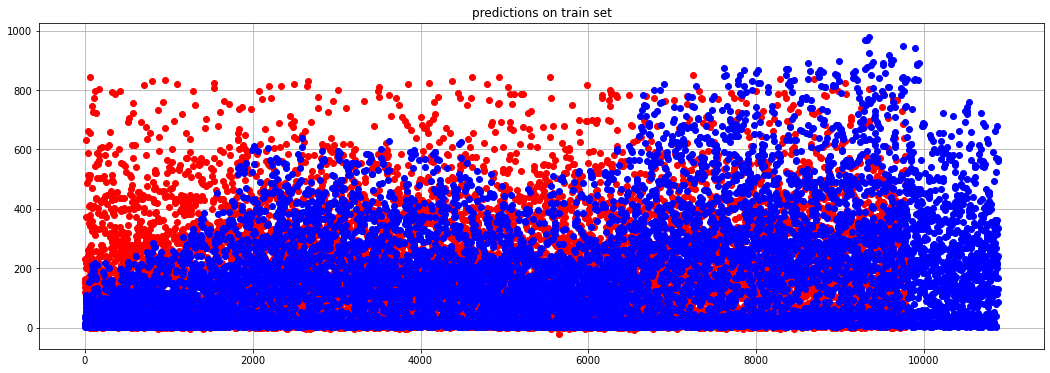

In [22]:
plt.figure(figsize=(18, 6))
plt.title("predictions on train set")
plt.plot(y_pred, "ro")
plt.plot(y_train, "bo")
plt.grid(True)
plt.show();

### Submission

In [ ]:
test_orig = pd.read_csv("test.csv")

In [ ]:
# add engineered features
# feature engineering
test_orig["datetime"] = pd.to_datetime(test_orig["datetime"])

# this way I add 3 engineered features
test_orig["hour"] = test_orig["datetime"].dt.hour
# test_orig['month'] = test_orig['datetime'].dt.month
test_orig["day"] = test_orig["datetime"].dt.day
test_orig["year"] = test_orig["datetime"].dt.year

In [ ]:
v_test = test_orig[features]

In [ ]:
score_test = model.predict(v_test)

In [ ]:
df_sub = pd.read_csv("sampleSubmission.csv")

In [ ]:
df_sub["count"] = score_test

In [ ]:
condition = df_sub["count"] < 0

df_sub.loc[condition, "count"] = 0

In [ ]:
df_sub.describe()

In [ ]:
FILE_SUB = "submission7.csv"

df_sub.to_csv(FILE_SUB, index=False)

In [ ]:
!kaggle competitions submit -c "bike-sharing-demand" -f $FILE_SUB -m "sub7"